## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "validation", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    if split=="train" or split=="validation":
        f_in = ROOT_PATH + "train" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        
        if split == "train":
            inputs = inputs[:inputs.shape[0]*4//5]
        else:
            inputs = inputs[inputs.shape[0]*4//5:]
        
        f_out = ROOT_PATH + "train" + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        if split == "train":
            outputs = outputs[:outputs.shape[0]*4//5]
        else:
            outputs = outputs[outputs.shape[0]*4//5:]
    else:
        f_in = ROOT_PATH + "test" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        outputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)
        else:
            #normalize start pos
            inp = self.inputs[idx]-data[0][0]
            out = self.outputs[idx]-data[0][0]
            data = (inp, out)

        return data
    
#     def split(self, split_ratio=0.2):
#         valid_size = round(split_ratio * len(self.inputs))
#         train_size = len(self.inputs) - valid_size

#         return random_split(self, [train_size, valid_size])

def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))

    #normalize start pos
    inp -= data[0][0]
    out -= data[0][0]
    return (inp, out)


# Data Analysis

In [3]:
import matplotlib.pyplot as plt
train_datasets = [ArgoverseDataset(city, "train") for city in cities]
val_datasets = [ArgoverseDataset(city, "validation") for city in cities]
test_datasets = [ArgoverseDataset(city, "test") for city in cities]

print("Dataset Sizes:")
train_size_string = "\t Training: "
train_total = 0
val_size_string = "\t Validation: "
val_total = 0
test_size_string = "\t Test: "
test_total = 0
for i, city in enumerate(cities):
    train_size_string += city+"- "+str(len(train_datasets[i]))+", "
    train_total += len(train_datasets[i])
    val_size_string += city+"- "+str(len(val_datasets[i]))+", "
    val_total += len(val_datasets[i])
    test_size_string += city+"- "+str(len(test_datasets[i]))+", "
    test_total += len(test_datasets[i])
train_size_string += "total- "+str(train_total)
val_size_string += "total- "+str(val_total)
test_size_string += "total- "+str(test_total)
print(train_size_string)
print(val_size_string)
print(test_size_string)
print()

print("Data Dimensions: input- %s, output- %s" % \
      (str(train_datasets[0][0][0].shape), str(train_datasets[0][0][1].shape)))
print()

Dataset Sizes:
	 Training: austin- 34432, miami- 44023, pittsburgh- 34835, dearborn- 19572, washington-dc- 20595, palo-alto- 9594, total- 163051
	 Validation: austin- 8609, miami- 11006, pittsburgh- 8709, dearborn- 4893, washington-dc- 5149, palo-alto- 2399, total- 40765
	 Test: austin- 6325, miami- 7971, pittsburgh- 6361, dearborn- 3671, washington-dc- 3829, palo-alto- 1686, total- 29843

Data Dimensions: input- (50, 2), output- (60, 2)



------------------------------------POSITION HEATMAPS--------------------------------------


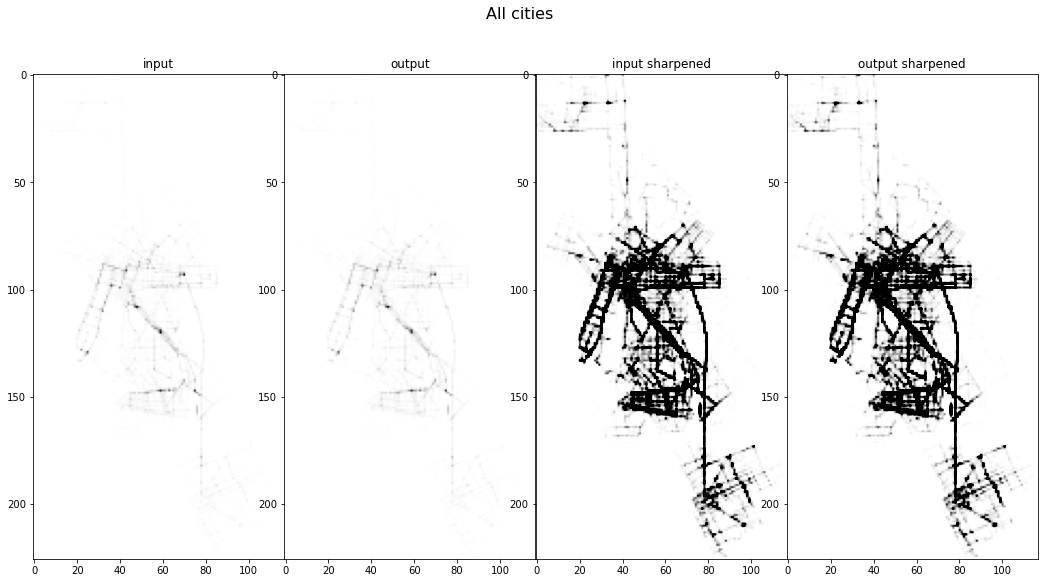

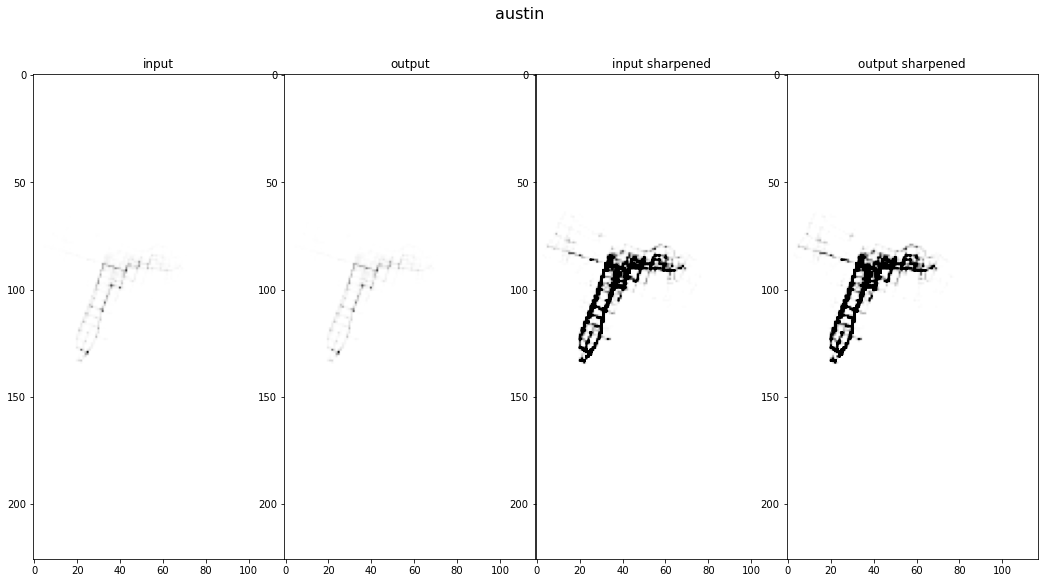

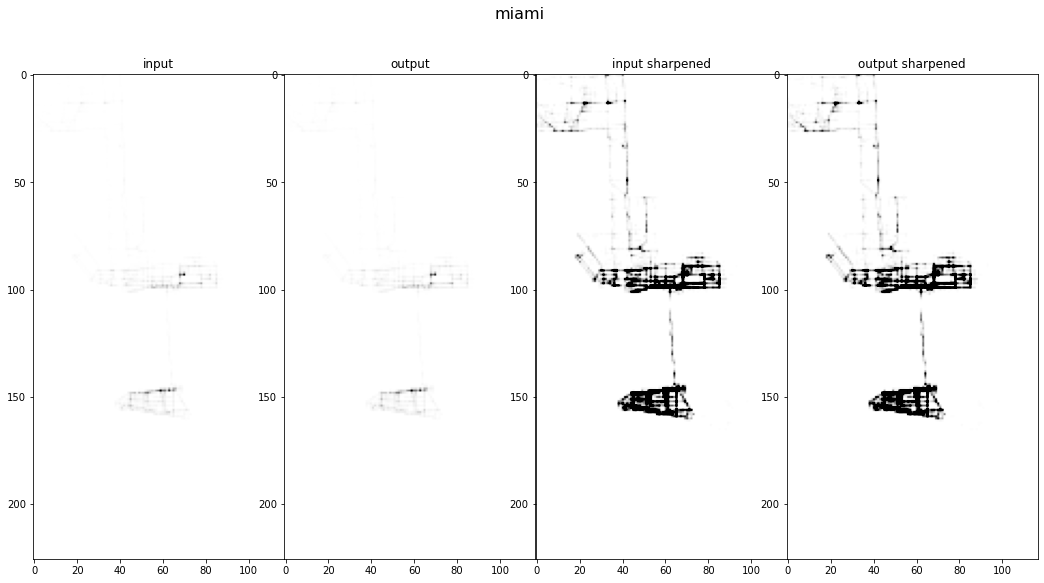

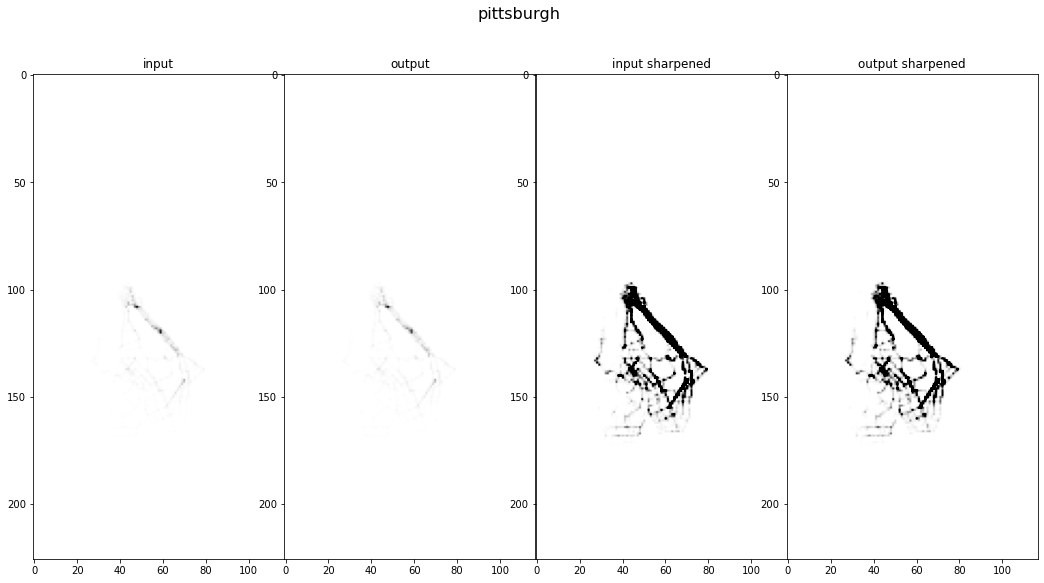

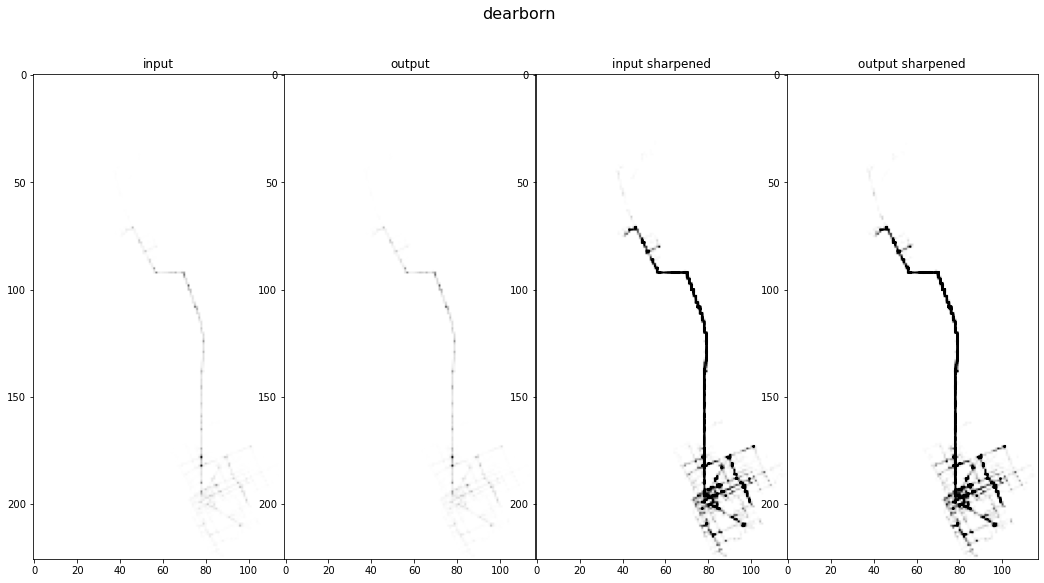

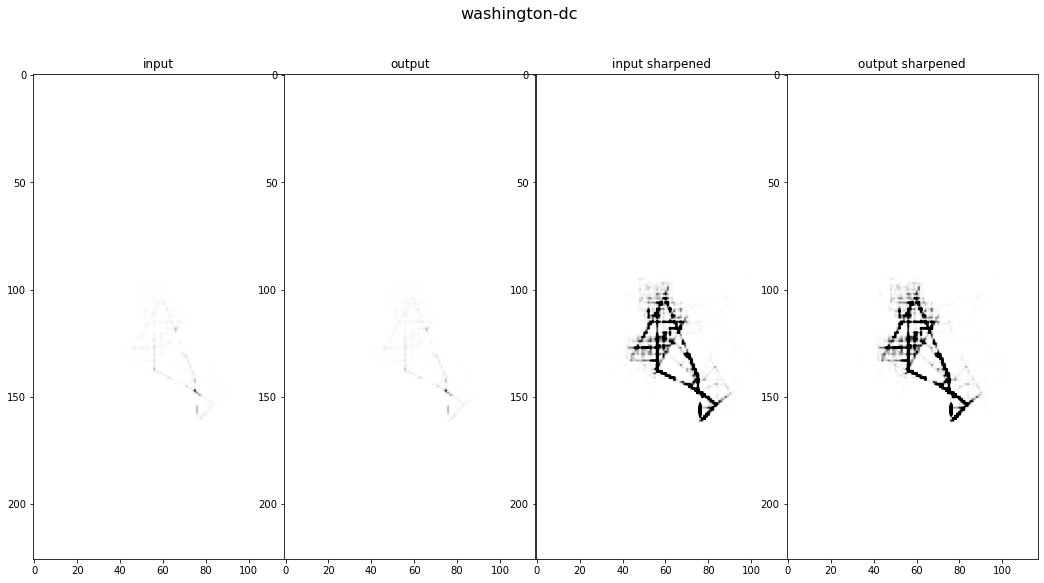

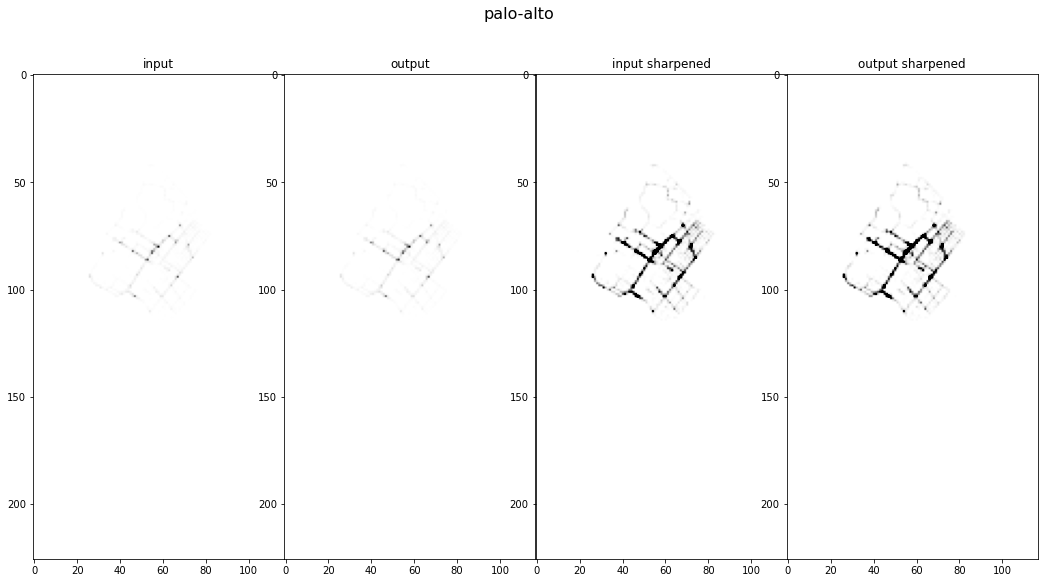

In [4]:
# Get heatmap bounds
max_x = float("-inf")
min_x = float("inf")
max_y = float("-inf")
min_y = float("inf")
for datasets in [train_datasets, val_datasets]:
    for dataset in datasets:
        for i in range(len(dataset)):
            inp, out = dataset[i]
            max_x = max([max_x, np.max(inp[:, 0]), np.max(out[:, 0])])
            min_x = min([min_x, np.min(inp[:, 0]), np.min(out[:, 0])])
            max_y = max([max_y, np.max(inp[:, 1]), np.max(out[:, 1])])
            min_y = min([min_y, np.min(inp[:, 1]), np.min(out[:, 1])])
max_x, min_x, max_y, min_y = int(max_x)+1, int(min_x)-1, int(max_y)+1, int(min_y)-1

# Generate heatmaps for training data
factor = 100 # group together positions into factorXfactor chunks in order to generate more informative heat map
inp_heatmap_list = [np.zeros((int(max_x - min_x)//factor+1, int(max_y - min_y)//factor+1)) \
                   for _ in datasets]
out_heatmap_list = [np.zeros((int(max_x - min_x)//factor+1, int(max_y - min_y)//factor+1)) \
                   for _ in datasets]
for datasets in [train_datasets, val_datasets]:
    for dataset, inp_heatmap, out_heatmap in zip(datasets, inp_heatmap_list, out_heatmap_list):
        for i in range(len(dataset)):
            inp, out = dataset[i]
            inp, out = np.rint(inp).astype(int), np.rint(out).astype(int)
            inp_heatmap[(inp[:, 0] - min_x)//factor, (inp[:, 1] - min_y)//factor] += 1
            out_heatmap[(out[:, 0] - min_x)//factor, (out[:, 1] - min_y)//factor] += 1

# Get and display combined heatmap
print("------------------------------------POSITION HEATMAPS--------------------------------------")
fig, axs = plt.subplots(1,4, figsize=(18, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities", fontsize=16)
inp_heatmap = sum(inp_heatmap_list)
out_heatmap = sum(out_heatmap_list)
axs[0].set_title("input")
axs[0].imshow(inp_heatmap, cmap="Greys")
axs[1].set_title("output")
axs[1].imshow(out_heatmap, cmap="Greys")
# add a ceiling to the maximum value to generate "sharpened" heat map 
sharpener = 50
axs[2].set_title("input sharpened")
axs[2].imshow(inp_heatmap, vmax=sharpener, cmap="Greys")
axs[3].set_title("output sharpened")
axs[3].imshow(out_heatmap, vmax=sharpener, cmap="Greys")

# display heatmap for each city
for i, name in enumerate(cities):
    fig, axs = plt.subplots(1,4, figsize=(18, 9), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    fig.suptitle(name, fontsize=16)
    axs[0].set_title("input")
    axs[0].imshow(inp_heatmap_list[i], cmap="Greys")
    axs[1].set_title("output")
    axs[1].imshow(out_heatmap_list[i], cmap="Greys")
    axs[2].set_title("input sharpened")
    axs[2].imshow(inp_heatmap_list[i], vmax = sharpener, cmap="Greys")
    axs[3].set_title("output sharpened")
    axs[3].imshow(out_heatmap_list[i], vmax=sharpener, cmap="Greys")

------------------------------------VELOCITY HISTOGRAMS--------------------------------------


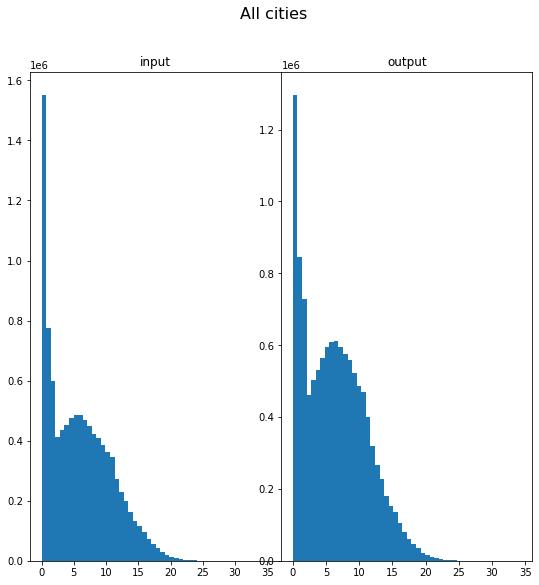

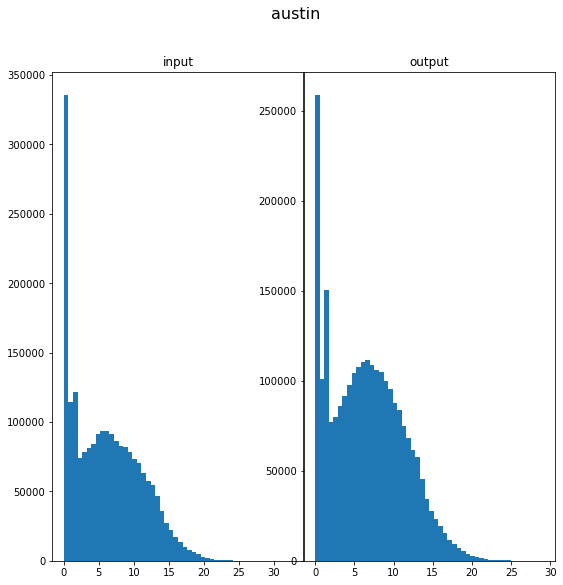

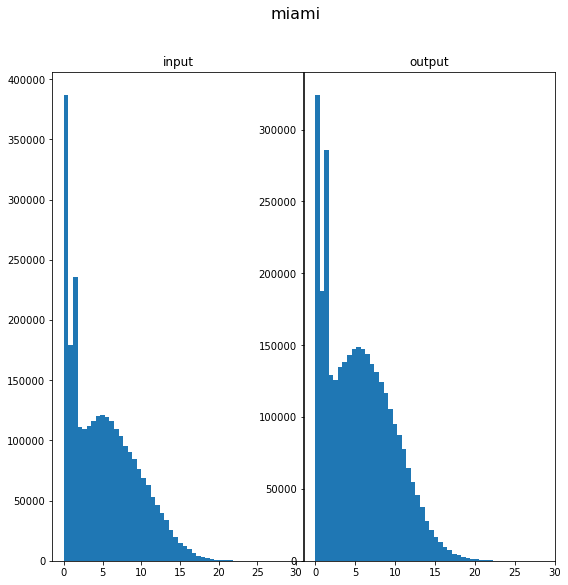

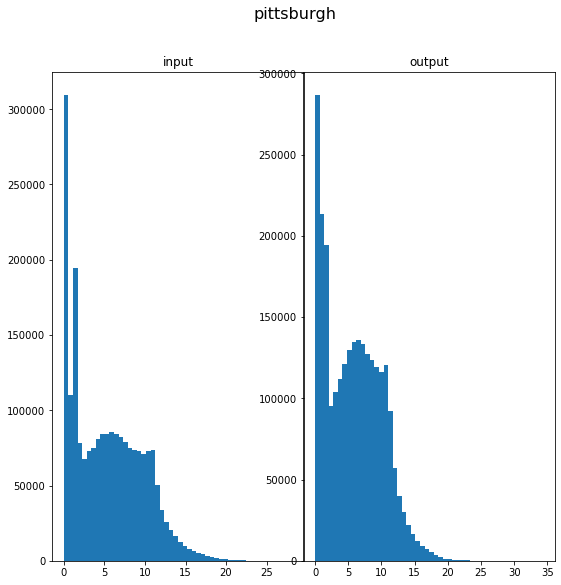

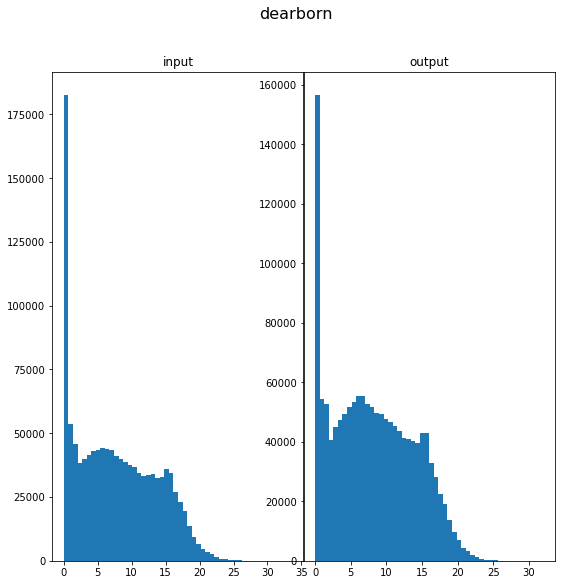

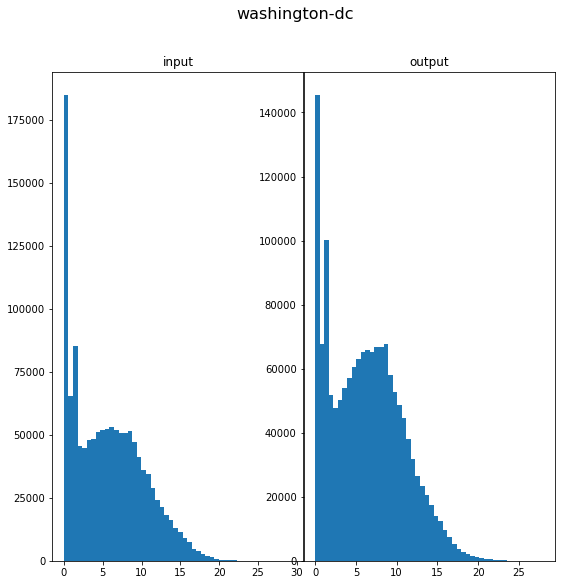

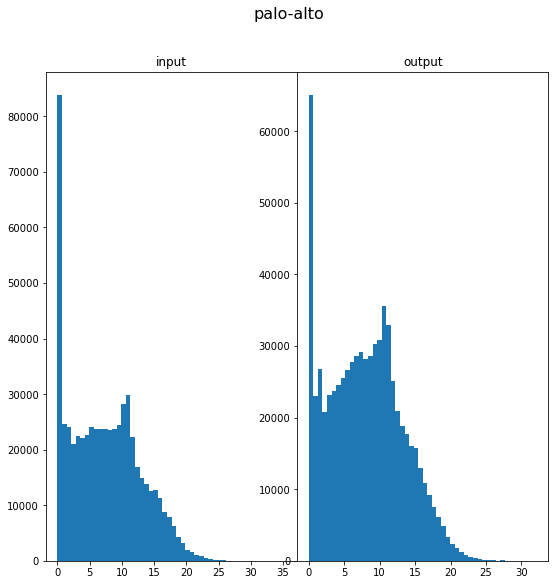

In [15]:
import itertools

inp_speeds_list = [[] for _ in datasets]
out_speeds_list = [[] for _ in datasets]
for datasets in [train_datasets, val_datasets]:
    for dataset, inp_speeds, out_speeds in zip(datasets, inp_speeds_list, out_speeds_list):
        for i in range(len(dataset)):
            inp, out = dataset[i]
            inp_s = np.linalg.norm(inp[1:] - inp[:-1], axis=1)*10
            out_s = np.linalg.norm(out[1:] - out[:-1], axis=1)*10
            for speed in inp_s:
                inp_speeds.append(speed)
            for speed in out_s:
                out_speeds.append(speed)

print("------------------------------------VELOCITY HISTOGRAMS--------------------------------------")
fig, axs = plt.subplots(1,2, figsize=(9, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities", fontsize=16)
inp_speeds = list(itertools.chain(*inp_speeds_list))
out_speeds = list(itertools.chain(*out_speeds_list))
bins = 50
axs[0].set_title("input")
axs[0].hist(inp_speeds, bins=bins)
axs[1].set_title("output")
axs[1].hist(out_speeds, bins=bins)

for i, name in enumerate(cities):
    fig, axs = plt.subplots(1,2, figsize=(9, 9), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    fig.suptitle(name, fontsize=16)
    axs[0].set_title("input")
    axs[0].hist(inp_speeds_list[i], bins=bins)
    axs[1].set_title("output")
    axs[1].hist(out_speeds_list[i], bins=bins)

## Sample a batch of data and visualize 

In [3]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
# for i_batch, sample_batch in enumerate(train_loader):
#     if i_batch <= 5:
#         continue
#     inp, out = sample_batch
#     """
#     TODO:
#       implement your Deep learning model
#       implement training routine
#     """
#     show_sample_batch(sample_batch)
#     break

# Model Constants

In [17]:
batch_sz = 32  # batch size
input_size = 2
hidden_size = 128
output_size = 2
inp_seq_len = 50
num_epochs = 20
lr = 1e-3

# Model Training

In [20]:
from models import LSTM
from tqdm import tqdm

city_loss = dict()

for city in cities:
    city_loss[city]=dict()
    print(f"Training model for {city}")
    train_dataset  = ArgoverseDataset(city = city, split = "train", transform=transform)
    train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
    val_dataset = ArgoverseDataset(city = city, split = "validation")
    val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
    val_iter = iter(val_loader)

    PATH = f"./models/{city}_best.pt"
    best_err = 10000000000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rnn = LSTM(input_size, hidden_size, output_size, device).cuda()
    criterion = torch.nn.MSELoss()
    criterion.to(device)
    opt = torch.optim.Adam(rnn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    # scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

    print_every = 1000
    val_every = 8
    plot_every = 500 / (batch_sz/4)
    train_loss = 0
    val_loss = 0
    train_losses = [-1]
    val_losses = [-1]
    # fig = plt.figure()

    rnn.train()
    for epoch in range(num_epochs):
        current_loss = 0
        val_iter = iter(val_loader)
        for s_num, (x, y) in tqdm(enumerate(train_loader), \
                                  "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
            x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

            opt.zero_grad()
            loss = 0

            y_hat = rnn(x)
            loss = criterion(y_hat, y)

            loss.backward()
            opt.step()

            # Validate every so often
            if s_num % val_every == 0:
                with torch.no_grad():
                    rnn.eval()
                    vx, vy = next(val_iter)
                    vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                    vy_hat = rnn(vx)
                    val_loss += criterion(vy_hat, vy)
                    del vx
                    del vy
                    rnn.train()

            # Print losses every so often
    #         if s_num % display_every == 0:
    #             with torch.no_grad():
    #                 show_sample_batch((y[:4].cpu(), y_hat[:4].cpu()))
    #                 rnn.eval()
    #                 vx, vy = next(val_iter)
    #                 vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
    #                 vy_hat = rnn(vx)
    #                 val_losses.append(criterion(vy_hat, vy))
    #                 show_sample_batch((vy[:4].cpu(), vy_hat[:4].cpu()))
    #                 del vx
    #                 del vy
    #                 rnn.train()

            # Keep track of average losses
            current_loss += loss.item()
            if s_num != 0 and s_num % plot_every == 0:
                with torch.no_grad():
                    train_losses.append(current_loss / plot_every)
                    current_loss = 0
                    val_losses.append(val_loss / plot_every)
                    val_loss = 0
                if val_losses[-1] < best_err:
                    torch.save(rnn, PATH)
                    best_err = val_losses[-1]
                scheduler.step(val_losses[-1])
            del x
            del y
    #     scheduler.step()
            
    city_loss[city]["train"] = train_losses
    city_loss[city]["val"] = val_losses
    torch.save(rnn, f"./models/{city}.pt")

    del rnn
    del criterion
    del scheduler
    del opt
        

Training model for austin


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1076it [00:15, 68.27it/s]
val_loss: 157.567, best_val: 142.445, train_loss: 202.316, epoch #1: 1076it [00:15, 70.16it/s]
val_loss: 189.105, best_val: 142.445, train_loss: 66.317, epoch #2: 1076it [00:15, 69.24it/s]
val_loss: 89.032, best_val: 69.110, train_loss: 46.850, epoch #3: 1076it [00:15, 69.31it/s]
val_loss: 56.904, best_val: 56.904, train_loss: 44.453, epoch #4: 1076it [00:15, 70.97it/s]
val_loss: 62.607, best_val: 53.573, train_loss: 38.864, epoch #5: 1076it [00:16, 66.35it/s]
val_loss: 61.352, best_val: 53.573, train_loss: 45.514, epoch #6: 1076it [00:14, 73.02it/s]
val_loss: 52.561, best_val: 51.789, train_loss: 36.596, epoch #7: 1076it [00:14, 73.85it/s]
val_loss: 54.180, best_val: 49.108, train_loss: 42.543, epoch #8: 1076it [00:14, 73.41it/s]
val_loss: 59.200, best_val: 49.108, train_loss: 41.908, epoch #9: 1076it [00:13, 77.74it/s]
val_loss: 56.122, best_val: 48.973, train_loss: 43.150, epoch #10:

Training model for miami


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1376it [00:19, 70.40it/s]
val_loss: 124.328, best_val: 99.259, train_loss: 72.844, epoch #1: 1376it [00:19, 71.74it/s]
val_loss: 62.545, best_val: 52.542, train_loss: 29.186, epoch #2: 1376it [00:18, 75.31it/s]
val_loss: 52.607, best_val: 52.542, train_loss: 26.793, epoch #3: 1376it [00:18, 74.04it/s]
val_loss: 49.957, best_val: 44.684, train_loss: 26.195, epoch #4: 1376it [00:18, 72.84it/s]
val_loss: 40.258, best_val: 39.821, train_loss: 23.830, epoch #5: 1376it [00:17, 77.12it/s]
val_loss: 45.880, best_val: 39.821, train_loss: 25.300, epoch #6: 1376it [00:17, 78.13it/s]
val_loss: 42.395, best_val: 39.821, train_loss: 22.679, epoch #7: 1376it [00:19, 70.76it/s]
val_loss: 39.026, best_val: 36.432, train_loss: 24.564, epoch #8: 1376it [00:18, 75.07it/s]
val_loss: 41.282, best_val: 36.432, train_loss: 23.528, epoch #9: 1376it [00:19, 69.42it/s]
val_loss: 41.666, best_val: 36.432, train_loss: 22.634, epoch #10: 137

Training model for pittsburgh


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1089it [00:14, 74.13it/s]
val_loss: 117.490, best_val: 104.175, train_loss: 150.743, epoch #1: 1089it [00:14, 75.04it/s]
val_loss: 126.149, best_val: 104.175, train_loss: 48.999, epoch #2: 1089it [00:15, 69.25it/s]
val_loss: 42.988, best_val: 36.923, train_loss: 31.007, epoch #3: 1089it [00:16, 67.73it/s]
val_loss: 63.465, best_val: 36.923, train_loss: 28.420, epoch #4: 1089it [00:15, 69.65it/s]
val_loss: 34.011, best_val: 31.187, train_loss: 22.870, epoch #5: 1089it [00:15, 72.05it/s]
val_loss: 34.383, best_val: 27.002, train_loss: 26.563, epoch #6: 1089it [00:13, 81.42it/s]
val_loss: 33.942, best_val: 27.002, train_loss: 24.105, epoch #7: 1089it [00:13, 78.24it/s]
val_loss: 31.390, best_val: 26.246, train_loss: 25.610, epoch #8: 1089it [00:13, 78.20it/s]
val_loss: 29.785, best_val: 26.246, train_loss: 24.257, epoch #9: 1089it [00:14, 73.49it/s]
val_loss: 29.280, best_val: 26.246, train_loss: 24.233, epoch #10:

Training model for dearborn


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 612it [00:08, 72.26it/s]
val_loss: 281.444, best_val: 281.444, train_loss: 1082.426, epoch #1: 612it [00:08, 69.23it/s]
val_loss: 191.014, best_val: 191.014, train_loss: 381.651, epoch #2: 612it [00:09, 64.26it/s]
val_loss: 188.385, best_val: 188.385, train_loss: 167.275, epoch #3: 612it [00:08, 69.63it/s]
val_loss: 233.168, best_val: 188.385, train_loss: 92.757, epoch #4: 612it [00:08, 68.79it/s]
val_loss: 223.077, best_val: 188.385, train_loss: 56.054, epoch #5: 612it [00:09, 67.54it/s]
val_loss: 241.713, best_val: 185.121, train_loss: 43.751, epoch #6: 612it [00:08, 69.29it/s]
val_loss: 265.366, best_val: 185.121, train_loss: 33.880, epoch #7: 612it [00:08, 72.67it/s]
val_loss: 229.917, best_val: 179.671, train_loss: 25.050, epoch #8: 612it [00:09, 67.68it/s]
val_loss: 284.809, best_val: 179.671, train_loss: 21.698, epoch #9: 612it [00:08, 70.79it/s]
val_loss: 249.241, best_val: 179.671, train_loss: 19.638, e

Training model for washington-dc


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 644it [00:09, 70.74it/s]
val_loss: 128.888, best_val: 128.888, train_loss: 375.429, epoch #1: 644it [00:09, 69.60it/s]
val_loss: 139.912, best_val: 107.217, train_loss: 130.644, epoch #2: 644it [00:09, 70.74it/s]
val_loss: 134.364, best_val: 107.217, train_loss: 64.235, epoch #3: 644it [00:08, 71.74it/s]
val_loss: 45.830, best_val: 45.830, train_loss: 39.520, epoch #4: 644it [00:09, 71.13it/s]
val_loss: 44.493, best_val: 34.422, train_loss: 38.004, epoch #5: 644it [00:09, 71.07it/s]
val_loss: 49.273, best_val: 34.422, train_loss: 33.860, epoch #6: 644it [00:08, 72.00it/s]
val_loss: 33.740, best_val: 33.740, train_loss: 33.765, epoch #7: 644it [00:09, 66.16it/s]
val_loss: 30.074, best_val: 26.747, train_loss: 30.431, epoch #8: 644it [00:09, 70.45it/s]
val_loss: 31.070, best_val: 26.747, train_loss: 30.651, epoch #9: 644it [00:09, 67.25it/s]
val_loss: 31.357, best_val: 25.581, train_loss: 35.047, epoch #10: 644it 

Training model for palo-alto


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 300it [00:04, 72.72it/s]
val_loss: 383.852, best_val: 383.852, train_loss: 1838.916, epoch #1: 300it [00:04, 66.69it/s]
val_loss: 250.744, best_val: 250.744, train_loss: 948.700, epoch #2: 300it [00:04, 72.67it/s]
val_loss: 189.970, best_val: 189.970, train_loss: 568.792, epoch #3: 300it [00:04, 73.61it/s]
val_loss: 182.371, best_val: 182.371, train_loss: 371.084, epoch #4: 300it [00:04, 70.75it/s]
val_loss: 196.733, best_val: 182.371, train_loss: 264.451, epoch #5: 300it [00:04, 66.06it/s]
val_loss: 162.248, best_val: 162.248, train_loss: 178.869, epoch #6: 300it [00:04, 71.73it/s]
val_loss: 158.429, best_val: 158.429, train_loss: 134.243, epoch #7: 300it [00:04, 70.92it/s]
val_loss: 177.352, best_val: 158.429, train_loss: 102.428, epoch #8: 300it [00:04, 73.40it/s]
val_loss: 139.530, best_val: 139.530, train_loss: 79.881, epoch #9: 300it [00:03, 79.95it/s]
val_loss: 141.359, best_val: 139.530, train_loss: 67.1

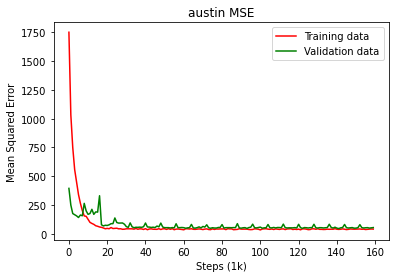

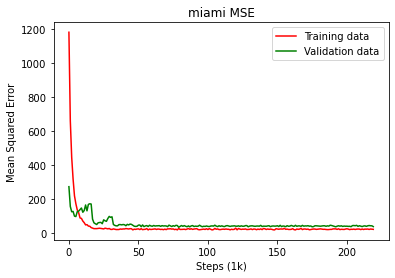

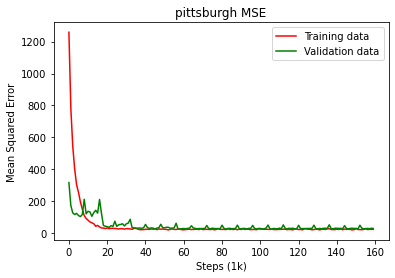

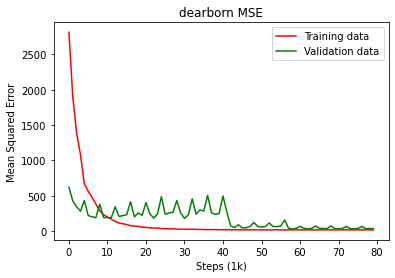

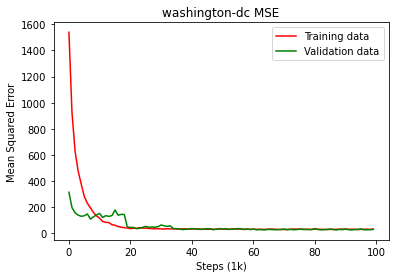

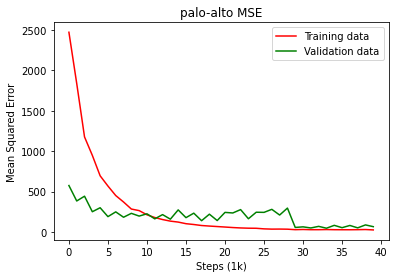

In [21]:
for i, city in enumerate(city_loss):
    plt.figure(i)
    plt.plot(range(len(city_loss[city]["train"][1:])), city_loss[city]["train"][1:],'-r', label="Training data")
    plt.plot(range(len(city_loss[city]["val"][1:])), city_loss[city]["val"][1:],'-g', label="Validation data")
    plt.gca().set_xlabel("Steps (1k)")
    plt.gca().set_ylabel("Mean Squared Error")
    plt.gca().set_title(f"{city} MSE")
    plt.legend()
    plt.show()

tensor(182.8196, device='cuda:0')
tensor(222.9868, device='cuda:0')
tensor(96.0055, device='cuda:0')
tensor(153.6493, device='cuda:0')
tensor(128.0621, device='cuda:0')
tensor(242.2827, device='cuda:0')


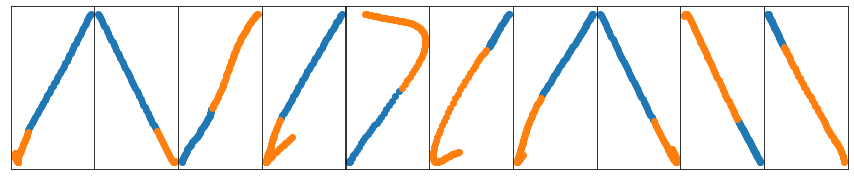

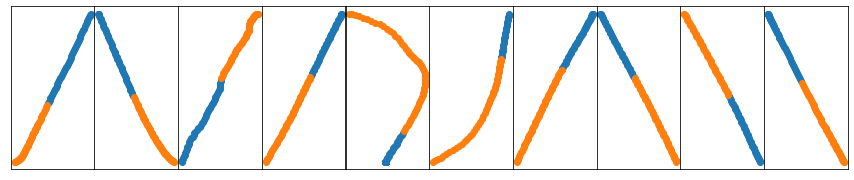

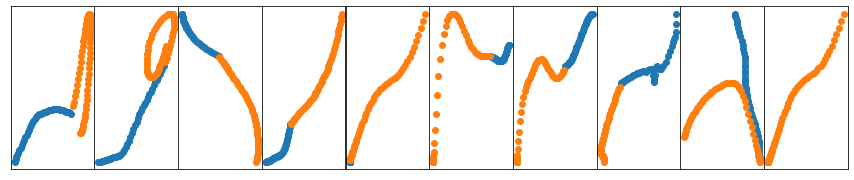

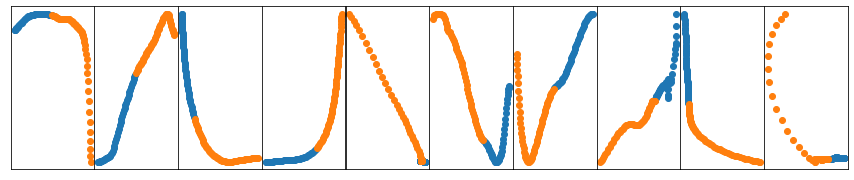

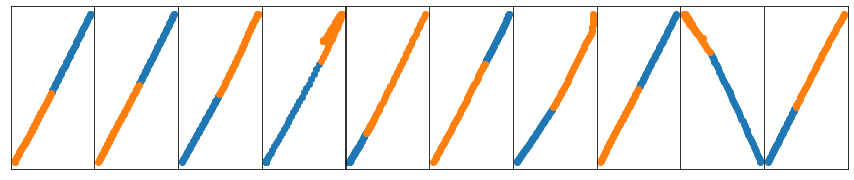

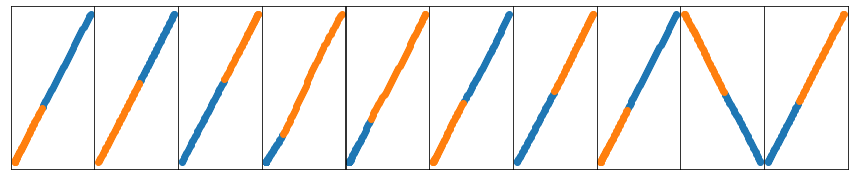

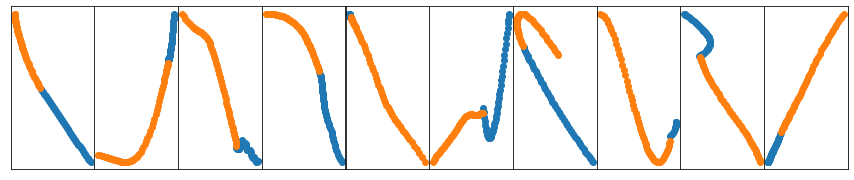

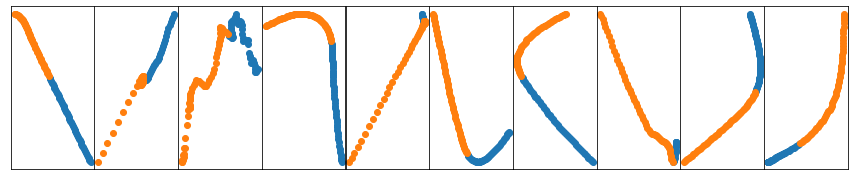

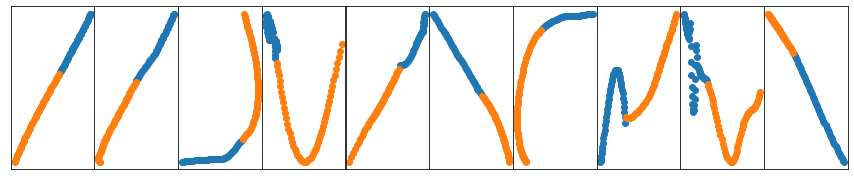

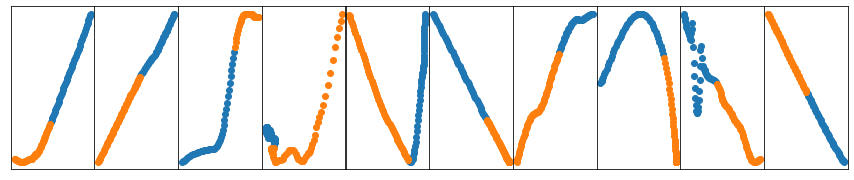

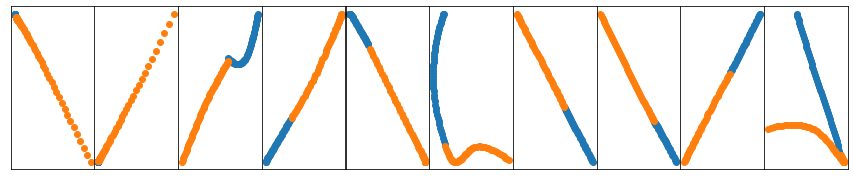

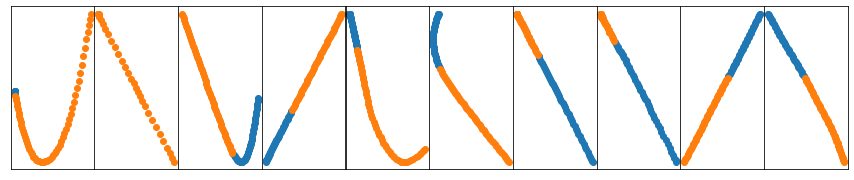

In [22]:
with torch.no_grad():
    for city in city_loss:
        rnn = torch.load(f"./models/{city}_best.pt").to(device)
        rnn.eval()
        val_dataset = ArgoverseDataset(city = city, split = "validation")
        val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
        x, y = next(iter(val_loader))
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
        y_hat = rnn(x[:, :inp_seq_len])
        loss = torch.nn.MSELoss()
        print(loss(y_hat, y))
        show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
#         del rnn
#         rnn = torch.load(f"./models/{city}.pt").to(device)
#         rnn.eval()
#         y_hat = rnn(x[:, :inp_seq_len])
#         loss = torch.nn.MSELoss()
#         print(loss(y_hat, y))
#         show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
        show_sample_batch((x[0:10, :inp_seq_len].cpu(), y[0:10, :].cpu()))

        del rnn

# Examining the submission format

In [23]:
import pandas as pd

In [7]:
sample_sub = pd.read_csv('./argo2/sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
%load_ext autoreload
%autoreload 2

In [9]:
from prediction import get_traj_pred

ModuleNotFoundError: No module named 'prediction'

Processing city austin
(6325, 50, 2)
(6325, 60, 2)
(6325, 120)
[  27.86433403 -580.02025069]
Processing city miami
(7971, 50, 2)
(7971, 60, 2)
(7971, 120)
[5928.7169812  1469.72844621]
Processing city pittsburgh
(6361, 50, 2)
(6361, 60, 2)
(6361, 120)
[4059.06160213  207.185043  ]
Processing city dearborn
(3671, 50, 2)
(3671, 60, 2)
(3671, 120)
[9384.91646135 3282.67523702]
Processing city washington-dc
(3829, 50, 2)
(3829, 60, 2)
(3829, 120)
[1540.78922806  720.24440437]
Processing city palo-alto
(1686, 50, 2)
(1686, 60, 2)
(1686, 120)
[ 566.7580094  1909.85977658]


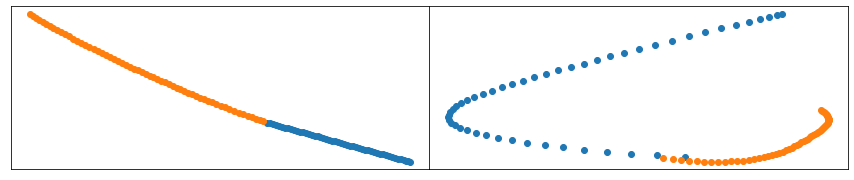

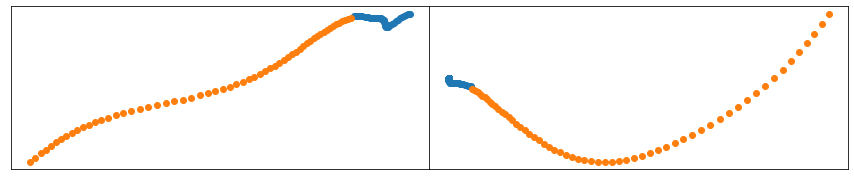

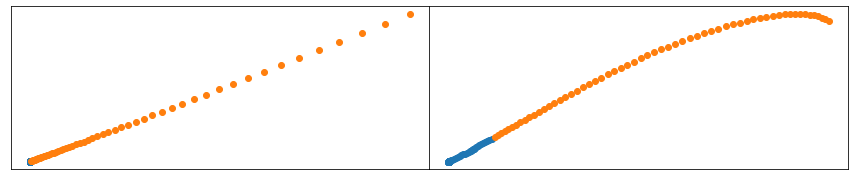

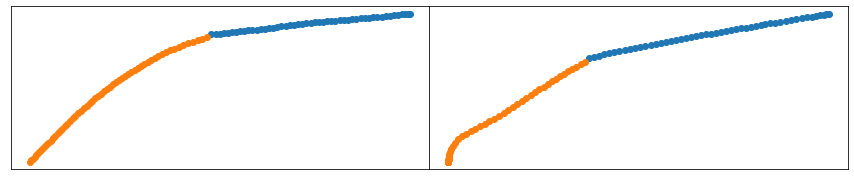

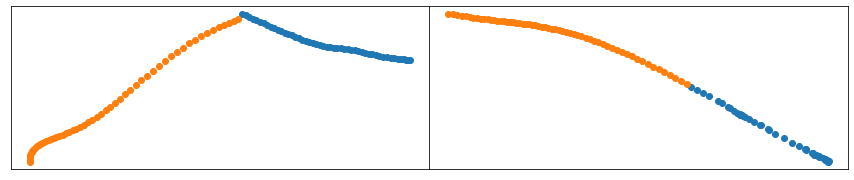

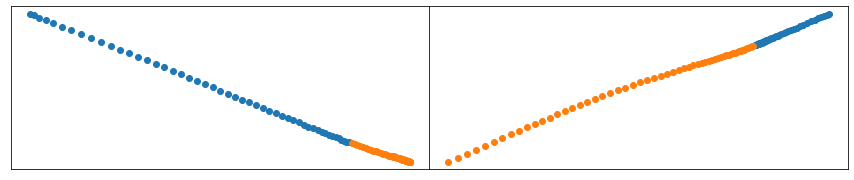

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])
for city_name in cities:

    print("Processing city", city_name)
    rnn = torch.load(f"./models/{city}_best.pt").to(device)
    rnn.eval()
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)
    normal_traj = np.zeros(shape=test_traj_in.shape)
    starts = np.zeros(shape=(test_traj_in.shape[0],2))
    for i in range(test_traj_in.shape[0]):
        starts[i, :] = test_traj_in[i][0]
#         print(starts[i])
#         print(test_traj_in[i].shape)
        normal_traj[i] = test_traj_in[i]-starts[i]
#         print(normal_traj[i][1])
#     print(normal_traj[0][0:9])
    traj = torch.from_numpy(normal_traj).to(torch.float32).to(device)
    test_pred_arr = rnn(traj).cpu().detach().numpy()
    print(test_pred_arr.shape)
    
    for i in range(test_traj_in.shape[0]):
        test_pred_arr[i]+=starts[i]
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    print(test_traj_in[0][0])
    show_sample_batch((torch.tensor(test_traj_in[0:2]), torch.tensor(test_pred_arr[0:2])))
    del rnn

In [26]:
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('./submissions/dropout.csv', index=None)